<a href="https://colab.research.google.com/github/mimi-1/DataProjects/blob/main/Cardio_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cardiovascular disease data
[Cardiovascular disease data ](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)



## Setup

In [74]:
import math
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score , roc_curve , auc
import matplotlib.pylab as plt
import seaborn as sns
!pip install dmba

from dmba import regressionSummary , classificationSummary
from dmba import liftChart , gainsChart

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
plt.style.use('classic')
%matplotlib inline

## Import dataset


Cardiovascular desease data contins following features:

Age | Objective Feature | age | int (days)<br />
Height | Objective Feature | height | int (cm) |<br />
Weight | Objective Feature | weight | float (kg) |<br />
Gender | Objective Feature | gender | categorical code |<br />
Systolic blood pressure | Examination Feature | ap_hi | int |<br />
Diastolic blood pressure | Examination Feature | ap_lo | int |<br />
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br />
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br />
Smoking | Subjective Feature | smoke | binary |<br />
Alcohol intake | Subjective Feature | alco | binary |<br />
Physical activity | Subjective Feature | active | binary |<br />
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |<br />

In [70]:
# file downloaded from Kaggle at Cardiovascular disease data
try:
  cardio_df = pd.read_csv("https://raw.githubusercontent.com/mimi-1/Datasets/main/cardio_train.csv",sep=";",index_col=0)
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
else:
    print("Data were loaded to cardio_df")
    backup = cardio_df.copy(deep=True)

Data were loaded to cardio_df


In [71]:
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


## Data Cleaning

In [40]:
cardio_df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
print("Min age in years: ", round(cardio_df.age.min()/365,0) )
print("Max age in years: ", round(cardio_df.age.max()/365,0) )

Min age in years:  30.0
Max age in years:  65.0


### Removing outliers
* Susp values for our response variable "ap_hi",
it should be positive and max value is too high (I dont beleive people can survive it). 

* The height 250cm seems unrealistics
* Weight 10 is a bit sus concidering the smallest height is 55cm.(baby?)
 
 Plan is to make negative values for pressure positive and remove outlaiers from Height, Weight, ap_hi(Systolic blood pressure), ap_lo(Diastolic) 

In [80]:
# renaming blood pressure columns for better usability
cardio_df.rename(columns={'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp'}, inplace=True)
# Setting all blood pressure values positive 
cardio_df.systolic_bp = abs(cardio_df.systolic_bp)
cardio_df.diastolic_bp = abs(cardio_df.diastolic_bp)
backup = cardio_df.copy(deep=True) #jic i do something bad


In [89]:
# cardio_df = backup.copy(deep=True)
cardio_df.describe()

,age,height,weight,systolic_bp,diastolic_bp,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.841429,96.632414,0.088129,0.053771,0.803729,0.499700
std,2467.251667,8.210126,14.395757,153.991223,188.471505,0.283484,0.225568,0.397179,0.500003
min,10798.000000,55.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000


In [108]:

#Removing outliers

fields_with_outliers = ["systolic_bp","diastolic_bp","height","weight"]

for field in fields_with_outliers:
  q_l = int(cardio_df[field].quantile(q=0.025))
  q_h = int(cardio_df[field].quantile(q=0.975))
  cardio_df = cardio_df[ (cardio_df[field] > q_l) & (cardio_df[field] < q_h) ]
cardio_df.describe()





,age,height,weight,systolic_bp,diastolic_bp,smoke,alco,active,cardio
count,14995.000000,14995.000000,14995.000000,14995.000000,14995.000000,14995.000000,14995.00000,14995.000000,14995.000000
mean,19997.950850,164.450550,77.184648,134.931977,85.648416,0.094565,0.06062,0.801267,0.705035
std,2303.706576,6.654301,11.861431,5.310065,5.025243,0.292623,0.23864,0.399060,0.456042
min,14287.000000,151.000000,56.000000,121.000000,71.000000,0.000000,0.00000,0.000000,0.000000
25%,18376.500000,160.000000,68.000000,130.000000,80.000000,0.000000,0.00000,1.000000,0.000000
50%,20338.000000,165.000000,76.000000,135.000000,90.000000,0.000000,0.00000,1.000000,1.000000
75%,21857.500000,170.000000,85.000000,140.000000,90.000000,0.000000,0.00000,1.000000,1.000000
max,23675.000000,179.000000,109.500000,149.000000,99.000000,1.000000,1.00000,1.000000,1.000000


### Setting up categorical variables for usability 


In [109]:
# create a dictionary to map ineger values to categorical values
gender_map={1:'female',2:'male'}
cholesterol_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
glucose_map={1: 'normal', 2: 'above average', 3: 'well above normal'}

cardio_df['gender'] = cardio_df['gender'].replace(gender_map)
cardio_df['cholesterol'] = cardio_df['cholesterol'].replace(cholesterol_map)
cardio_df['gluc'] = cardio_df['gluc'].replace(glucose_map)

#Changing object datataypes to categorical
cardio_df['cholesterol'] = cardio_df['cholesterol'].astype('category')
cardio_df['gluc'] = cardio_df['gluc'].astype('category')
cardio_df['gender'] = cardio_df['gender'].astype('category')


,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
1,20228,female,156,85.0,140,90,well above normal,normal,0,0,1,1
9,22113,female,157,93.0,130,80,well above normal,normal,0,0,1,0
12,22584,male,178,95.0,130,90,well above normal,well above normal,0,0,1,1


In [112]:
#using only random 1000 records 
sample_df = cardio_df.sample(n=1000,random_state=1)


Bodymass Index $BMI = \frac{Weight_{kg}}{Height_{m}^2}$

In [137]:
#Create variable containing bodymass index 
cardio_df["BMI"] = round(cardio_df["weight"]/((0.01*cardio_df["height"])**2),2)
cardio_df.describe()

,age,height,weight,systolic_bp,diastolic_bp,smoke,alco,active,cardio,BMI
count,14995.000000,14995.000000,14995.000000,14995.000000,14995.000000,14995.000000,14995.00000,14995.000000,14995.000000,14995.000000
mean,19997.950850,164.450550,77.184648,134.931977,85.648416,0.094565,0.06062,0.801267,0.705035,28.610900
std,2303.706576,6.654301,11.861431,5.310065,5.025243,0.292623,0.23864,0.399060,0.456042,4.602071
min,14287.000000,151.000000,56.000000,121.000000,71.000000,0.000000,0.00000,0.000000,0.000000,17.990000
25%,18376.500000,160.000000,68.000000,130.000000,80.000000,0.000000,0.00000,1.000000,0.000000,25.040000
50%,20338.000000,165.000000,76.000000,135.000000,90.000000,0.000000,0.00000,1.000000,1.000000,27.890000
75%,21857.500000,170.000000,85.000000,140.000000,90.000000,0.000000,0.00000,1.000000,1.000000,31.530000
max,23675.000000,179.000000,109.500000,149.000000,99.000000,1.000000,1.00000,1.000000,1.000000,47.800000


In [139]:
cardio_df.to_csv(r'CleanCardioDataset.csv', index=False)

## Exploratory Analysisys 

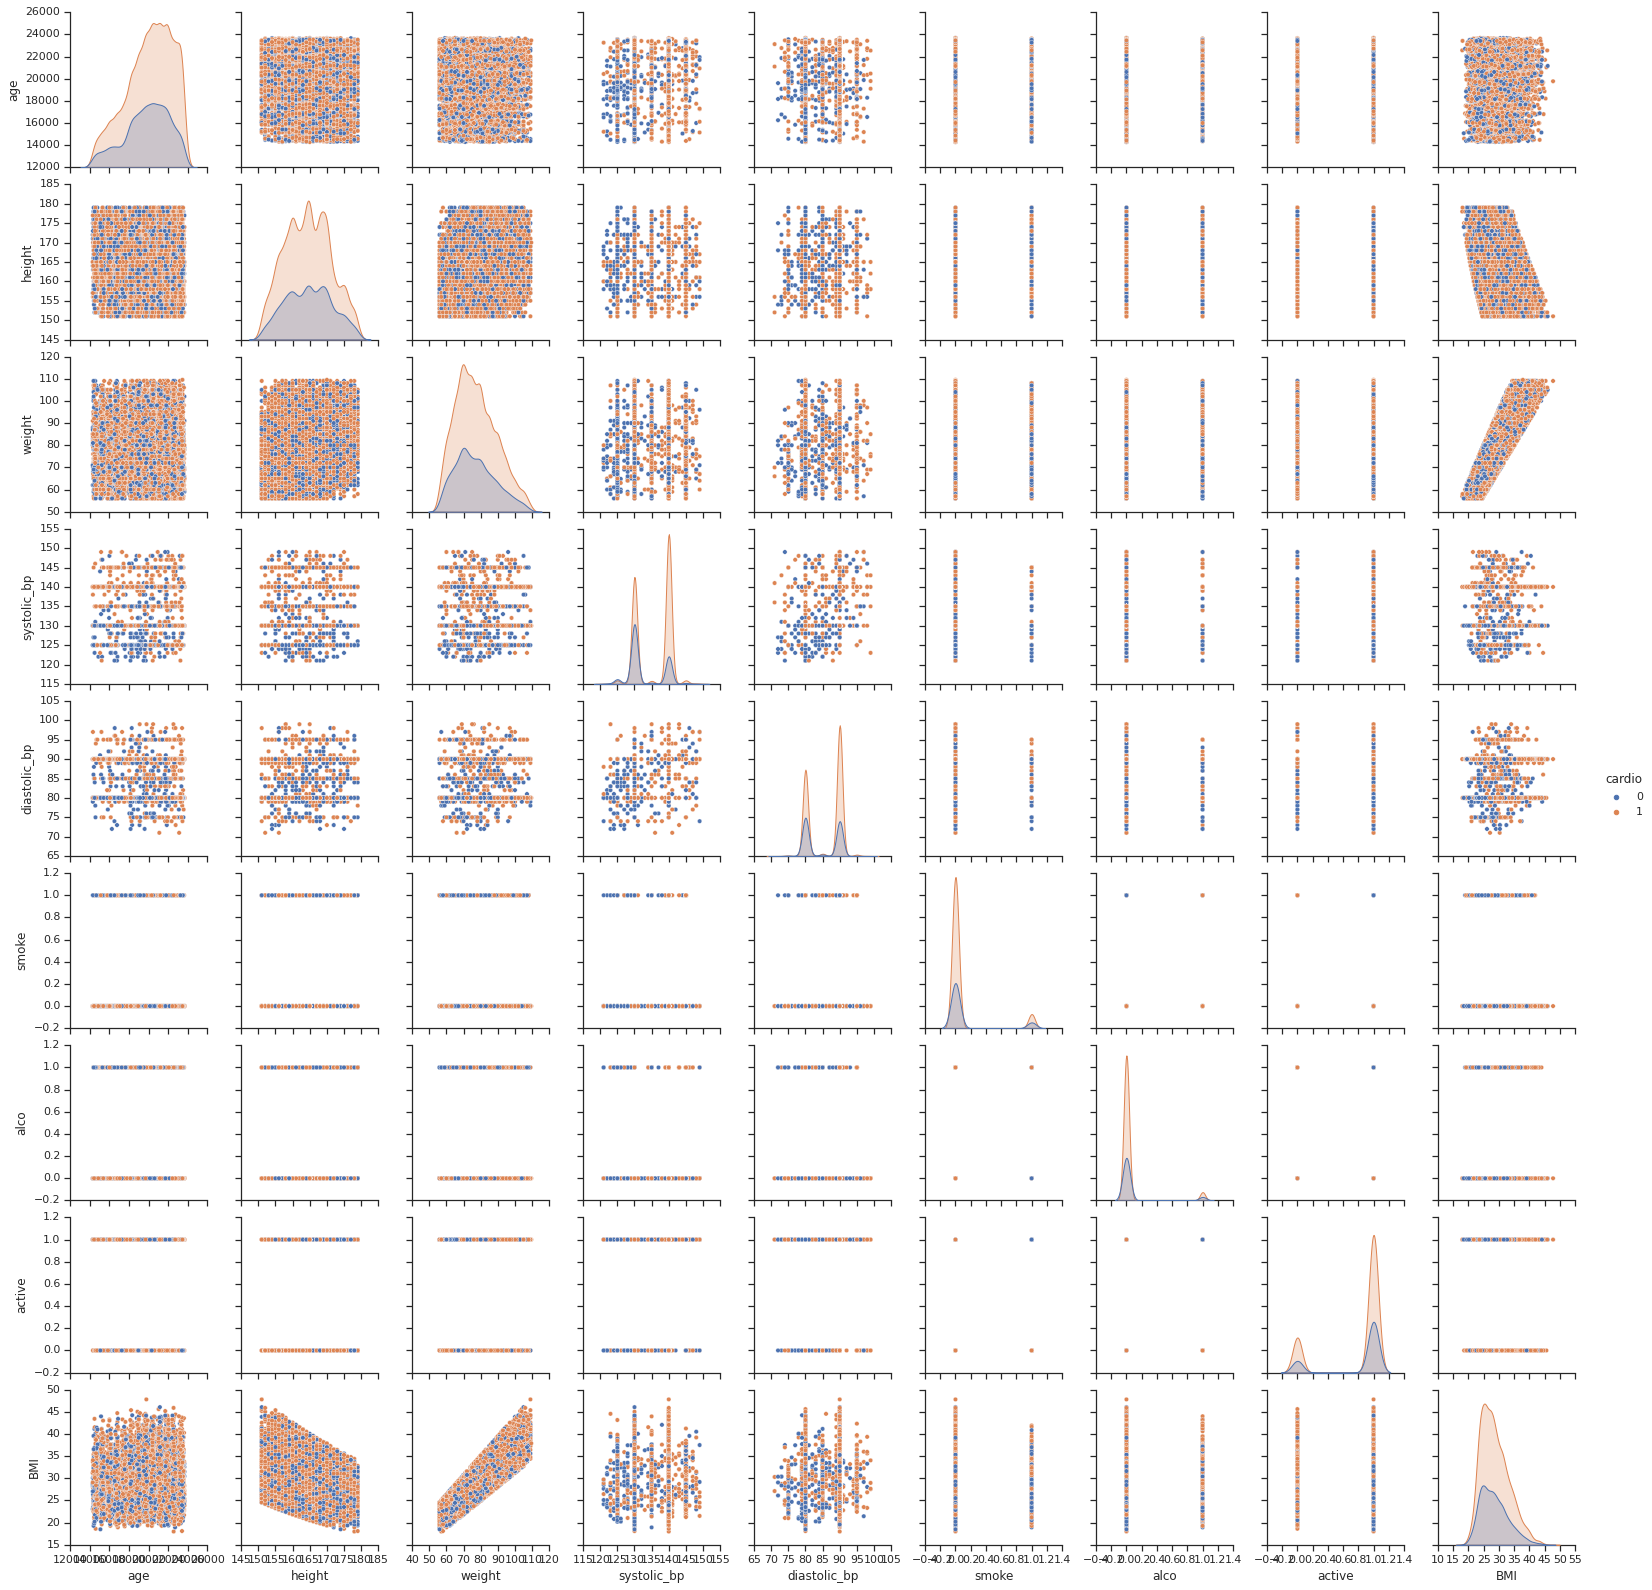

In [138]:
sns.set_theme(style="ticks")
sns.color_palette("Paired")
sns.pairplot(cardio_df, hue="cardio")

We will attempt regression anyway

<AxesSubplot:xlabel='height', ylabel='weight'>

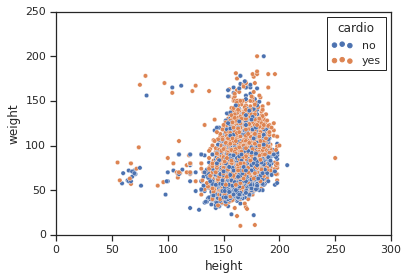

In [56]:
#Weight to height correlation
sns.scatterplot(data =cardio_df,y='weight', x='height', hue='cardio')

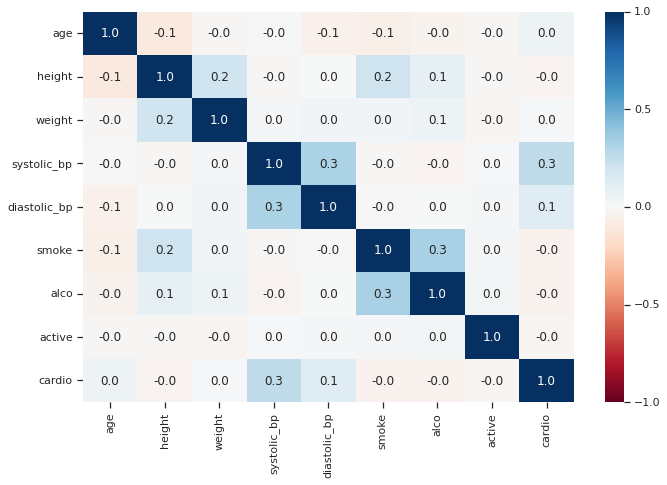

In [120]:
cardio_corr = sample_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(cardio_corr, annot=True , fmt =".1f", cmap="RdBu", center=0, ax=ax,vmin=-1,
vmax =1)
plt.show()

## Regression

In [129]:
predictors = ['age',"BMI","smoke","alco","gender","cholesterol","gluc", "active" ]
outcome = 'systolic_bp'
X = pd.get_dummies(sample_df [predictors], drop_first=True) 
y=sample_df[outcome]

X.head(4)

,age,BMI,smoke,alco,active,gender_male,cholesterol_normal,cholesterol_well above normal,gluc_normal,gluc_well above normal
id,,,,,,,,,,
70747,19576,25.00,0,0,1,0,1,0,1,0
86031,22669,22.04,0,0,0,1,0,0,1,0
57984,19740,25.56,0,0,1,0,1,0,1,0
39135,23365,28.09,0,0,1,1,1,0,1,0


In [130]:
# Split the data into training and validation
train_X, valid_X , train_y , valid_y = train_test_split (X, y, test_size=0.4 , random_state =1)
# Built the Linear Model based on the training data
cardio_lm = LinearRegression()
cardio_lm.fit(train_X , train_y)

# print coefficients
print(pd.DataFrame ({'Predictor': X.columns , 'coefficient': cardio_lm.coef_}))
print("Min and max trining outcome value", train_y.min(),train_y.max())     
# print performance measures (training data)
regressionSummary(train_y, cardio_lm.predict(train_X))


                       Predictor  coefficient
0                            age    -0.000026
1                            BMI     0.036884
2                          smoke    -0.589092
3                           alco    -1.058672
4                         active    -0.214474
5                    gender_male    -0.438147
6             cholesterol_normal    -1.602393
7  cholesterol_well above normal     0.353580
8                    gluc_normal    -0.192477
9         gluc_well above normal    -0.812182
Min and max trining outcome value 125 148

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 5.2637
            Mean Absolute Error (MAE) : 5.0332
          Mean Percentage Error (MPE) : -0.1526
Mean Absolute Percentage Error (MAPE) : 3.7379


with age systolic blood pressure is decreasing(slightly). Should we try to convert to years? 


In [127]:
#testing our model
# Use predict() to make predictions on a new set
cardio_lm_test = cardio_lm.predict(valid_X)
result =pd.DataFrame ({'Predicted': cardio_lm_test, 'Actual': valid_y, 'Residual': valid_y - cardio_lm_test})
print(result.head ())
#print performace measures(validation data)
regressionSummary(valid_y , cardio_lm_test)

        Predicted  Actual  Residual
id                                 
44692  134.235339     130 -4.235339
49993  134.483300     130 -4.483300
90816  133.962874     130 -3.962874
74767  133.908011     140  6.091989
10725  135.215940     140  4.784060

Regression statistics

                      Mean Error (ME) : 0.4084
       Root Mean Squared Error (RMSE) : 5.3687
            Mean Absolute Error (MAE) : 5.1036
          Mean Percentage Error (MPE) : 0.1474
Mean Absolute Percentage Error (MAPE) : 3.7795


# Validation Performance

id
44692    -4.235339
49993    -4.483300
90816    -3.962874
74767     6.091989
10725     4.784060
84739     5.802598
89503     3.498621
68639     5.736249
59236   -10.463295
Name: systolic_bp, dtype: float64
0.9775


<function matplotlib.pyplot.show(close=None, block=None)>

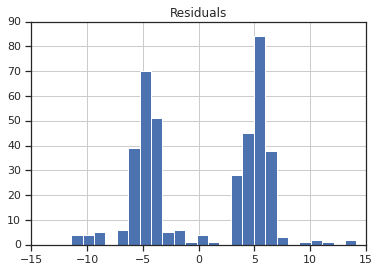

In [135]:
# Predictive accuracy measures and charts of prediction error distribution
# Validation Error - Evaluate Perfomance
all_residuals = valid_y - cardio_lm_test
print(all_residuals.head(9))
print( len(all_residuals[(all_residuals > - 10) & ( all_residuals < 10)]) / len(all_residuals))

pd.DataFrame({'Residuals': all_residuals }).hist(bins=25)
plt.show

Error are not distributed normally 